# Install modules (Just run it once the first time.)

In [1]:
# Support Python 3.8
# ! pip3 install matplotlib
# ! pip3 install numpy
# ! pip3 install tensorflow
# ! pip3 install pandas
# ! pip3 install opencv-python

# Import modules

In [2]:
# @title Imports

import os
from io import BytesIO
import tarfile
import tempfile
from six.moves import urllib

from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image

import tensorflow as tf

import cv2

2022-12-11 13:12:51.074640: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Model

In [3]:
#@title Helper methods

class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    # Extract frozen graph from tar archive.
    tar_file = tarfile.open(tarball_path)
    for tar_info in tar_file.getmembers():
      if self.FROZEN_GRAPH_NAME in os.path.basename(tar_info.name):
        file_handle = tar_file.extractfile(tar_info)
        graph_def = tf.compat.v1.GraphDef.FromString(file_handle.read())
        break

    tar_file.close()

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.compat.v1.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]
    return resized_image, seg_map


# Settings

In [4]:
# cityscape labels
LABEL_NAMES = np.asarray([
    'road','sidewalk','building',
    'wall','fence','pole','traffic light','traffic sign',
    'vegetation','terrain','sky','person','rider','car',
    'truck','bus','train','motorcycle','bicycle','unlabeled',
])

In [5]:
FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)

In [6]:
FULL_COLOR_MAP = np.array([
       [[  0,   0,   0]], # 'road'
       [[128,   0,   0]], # 'sidewalk'
       [[ 192, 192,   192]], # 'building'
       [[128, 128,   0]], # 'wall'
       [[  0,   0, 128]], # 'fence'
       [[128,   0, 128]], # 'pole'
       [[  0, 128, 128]], # 'traffic light'
       [[128, 128, 128]], # 'traffic sign'
       [[ 0,   192,   0]], # 'vegetation'
       [[192,   0,   0]], # 'terrain'
       [[ 64, 224,   208]], # 'sky'
       [[192, 128,   0]], # 'person'
       [[ 64,   0, 128]], # 'rider'
       [[192,   0, 128]], # 'car'
       [[ 64, 128, 128]], # 'truck'
       [[192, 128, 128]], # 'bus'
       [[  0,  64,   0]], # 'train'
       [[255,  0,   255]], # 'motorcycle'
       [[  64, 0,   0]], # 'bicycle'
       [[128, 192,   0]] # 'unlabeled'
])

In [7]:
path = './images/'

# Functions

In [8]:
def create_pascal_label_colormap():
  """Creates a label colormap used in PASCAL VOC segmentation benchmark.

  Returns:
    A Colormap for visualizing segmentation results.
  """
  colormap = np.zeros((256, 3), dtype=int)
  colormap = override_pascal_label_color_map(colormap)
  ind = np.arange(256, dtype=int)

  for shift in reversed(range(8)):
    for channel in range(3):
      colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

  return colormap

def override_pascal_label_color_map(original):
    """Override default color map by custom color map edited by FULL_COLOR_MAP
    Retruns:
      Customed Colormap
    """
    custommap = np.copy(original)
    for index, color in enumerate(FULL_COLOR_MAP):
        custommap[index] = color
    
    return custommap


def label_to_color_image(label):
  """Adds color defined by the dataset colormap to the label.

  Args:
    label: A 2D array with integer type, storing the segmentation label.

  Returns:
    result: A 2D array with floating type. The element of the array
      is the color indexed by the corresponding element in the input label
      to the PASCAL color map.

  Raises:
    ValueError: If label is not of rank 2 or its value is larger than color
      map maximum entry.
  """
  if label.ndim != 2:
    raise ValueError('Expect 2-D input label')

  colormap = create_pascal_label_colormap()

  if np.max(label) >= len(colormap):
    raise ValueError('label value too large.')

  return colormap[label]


def vis_segmentation(image, seg_map):
  """Visualizes input image, segmentation map and overlay view."""
  plt.figure(figsize=(15, 5))
  grid_spec = gridspec.GridSpec(1, 4, width_ratios=[6, 6, 6, 1])

  plt.subplot(grid_spec[0])
  plt.imshow(image)
  plt.axis('off')
  plt.title('input image')

  plt.subplot(grid_spec[1])
  seg_image = label_to_color_image(seg_map).astype(np.uint8)
  plt.imshow(seg_image)
  plt.axis('off')
  plt.title('segmentation map')

  plt.subplot(grid_spec[2])
  plt.imshow(image)
  plt.imshow(seg_image, alpha=0.7)
  plt.axis('off')
  plt.title('segmentation overlay')

  unique_labels = np.unique(seg_map)
  ax = plt.subplot(grid_spec[3])
  plt.imshow(
      FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation='nearest')
  ax.yaxis.tick_right()
  plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
  plt.xticks([], [])
  ax.tick_params(width=0.0)
  plt.grid('off')
  plt.show()

In [9]:
def mapping_single_file(path, file):
    original_im = cv2.imread(path + file)
    pilImg = Image.fromarray(np.uint8(original_im))
    resized_im, seg_map = MODEL.run(pilImg)
    return resized_im, seg_map

In [10]:
def calc_vegetation(seg_map):
    flaten_segmap = seg_map.flat
    a = np.array(flaten_segmap)
    # vegetationの割合
    return (len(np.where(a==FULL_LABEL_MAP[8])[0]) / seg_map.size) *100

# Download trained model

In [11]:
#@title Select and download models {display-mode: "form"}

# MODEL_NAME = 'mobilenetv2_coco_cityscapes_train' # 23MB
MODEL_NAME = 'deeplabv3_cityscapes_train' # 439MB
# MODEL_NAME = 'deeplab_cityscapes_xception71_trainfine' # 445MB
# MODEL_NAME = 'deeplab_cityscapes_xception71_trainvalfine' # 446MB

_DOWNLOAD_URL_PREFIX = 'http://download.tensorflow.org/models/'
_MODEL_URLS = {
    'mobilenetv2_coco_cityscapes_train':
        'deeplabv3_mnv2_cityscapes_train_2018_02_05.tar.gz',
    'deeplabv3_cityscapes_train':
        'deeplabv3_cityscapes_train_2018_02_06.tar.gz',
    'deeplab_cityscapes_xception71_trainfine':
        'deeplab_cityscapes_xception71_trainfine_2018_09_08.tar.gz',
    'deeplab_cityscapes_xception71_trainvalfine':
        'deeplab_cityscapes_xception71_trainvalfine_2018_09_08.tar.gz'
}
_TARBALL_NAME = 'deeplab_model.tar.gz'

model_dir = tempfile.mkdtemp()
tf.io.gfile.makedirs(model_dir)

download_path = os.path.join(model_dir, _TARBALL_NAME)
print('downloading model, this might take a while...')
urllib.request.urlretrieve(_DOWNLOAD_URL_PREFIX + _MODEL_URLS[MODEL_NAME],
                   download_path)
print('download completed! loading DeepLab model...')

MODEL = DeepLabModel(download_path)
print('model loaded successfully!')

downloading model, this might take a while...
download completed! loading DeepLab model...
model loaded successfully!


2022-12-11 13:13:05.488690: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Execute Segmentation

## mapping single file

edit variable "file" and execute.

if you don't need to show segmentaion info, comment out 'vis_segmentaion'


/var/folders/6f/6rhzl91s0lz8r397dzgrj2280000gn/T/ipykernel_57314/3246313260.py:47: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
2022-12-11 13:13:05.762007: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled


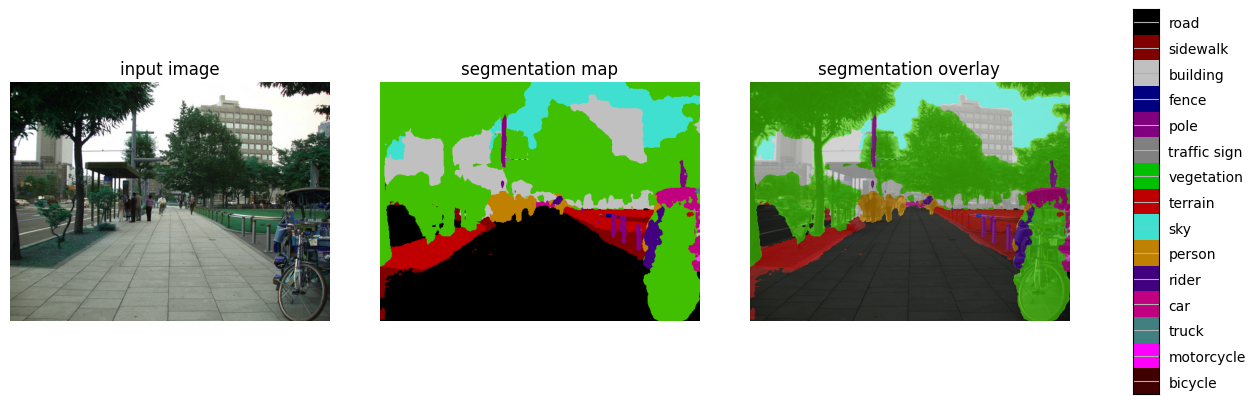

vegetation(%):34.689733593242366 


In [12]:
file = '34584.jpg'
resized_im, seg_map = mapping_single_file(path, file)
seg_image = label_to_color_image(seg_map).astype(np.uint8)
vis_segmentation(resized_im, seg_map)
print(f'vegetation(%):{calc_vegetation(seg_map)} ')

## mapping multiple file

execute mapping files under the 'path' variable (check the Setting sction)

if you don't need to show segmentaion info, comment out 'vis_segmentaion'


In [13]:
# mapping all file
# file_list = os.listdir(path)
# for _file in file_list:
#     print(f'filename: {_file}')
#     resized_im, seg_map = mapping_single_file(path, _file)
#     seg_image = label_to_color_image(seg_map).astype(np.uint8)
#     # vis_segmentation(resized_im, seg_map)
#     print(f'vegetation(%):{calc_vegetation(seg_map)} ')

filename: sapporo2.JPG


/var/folders/6f/6rhzl91s0lz8r397dzgrj2280000gn/T/ipykernel_57314/3246313260.py:47: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.LANCZOS instead.
  resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)


vegetation(%):80.70378492527615 
filename: 34584.jpg
vegetation(%):34.689733593242366 
filename: 34581.jpg
vegetation(%):52.59147579597141 
filename: 34583.jpg
vegetation(%):23.07860217673814 
filename: 34582.jpg
vegetation(%):65.32143437296945 
filename: sapporo.JPG
vegetation(%):49.49185753736192 
